In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

Reading and cleaning the data:

In [21]:
path = "/users/kellie/Documents/A College Life ^_^/CU Boulder/Earthlab - Analytics Hub/\
sonar_project/sonar-demo-master/sonar-demo-master/4km_sonardata/nasc_sonar.csv"

d = pd.read_csv(path)

d = d.query('NASC > 0')  # filter out zero-value NASC
d = d.assign(log_nasc = np.log(d.NASC))  # log transform of NASC
d = d.assign(closest_chlor_a = np.log(d.closest_chlor_a))
d = d.assign(depth_m = d.depth_m.astype(np.float64))
d = d.query('log_nasc < 17.5')

feats = [
    'Lon', 
    'Lat',
    'distance_from_shore_m',
    'depth_m',
    'log_nasc', 
    'wavelength', 
    'depth_bin'
]
filter_col = [col for col in d if (col.startswith('closest') or col in feats)]
d = d[filter_col]
d = d.dropna()
d.shape

(51712, 21)

In [20]:
print(type(d))

<class 'pandas.core.frame.DataFrame'>


In [3]:
wavelengths = d.wavelength.unique()
wavelengths.sort()
wavelengths

array([ 18,  38,  70, 120, 200], dtype=int64)

In [4]:
depth_bins = d.depth_bin.unique()
depth_bins

array(['0-250m', '250-500m', '500-750m'], dtype=object)

Fitting and evaluating models for each wavelength/bin combo:

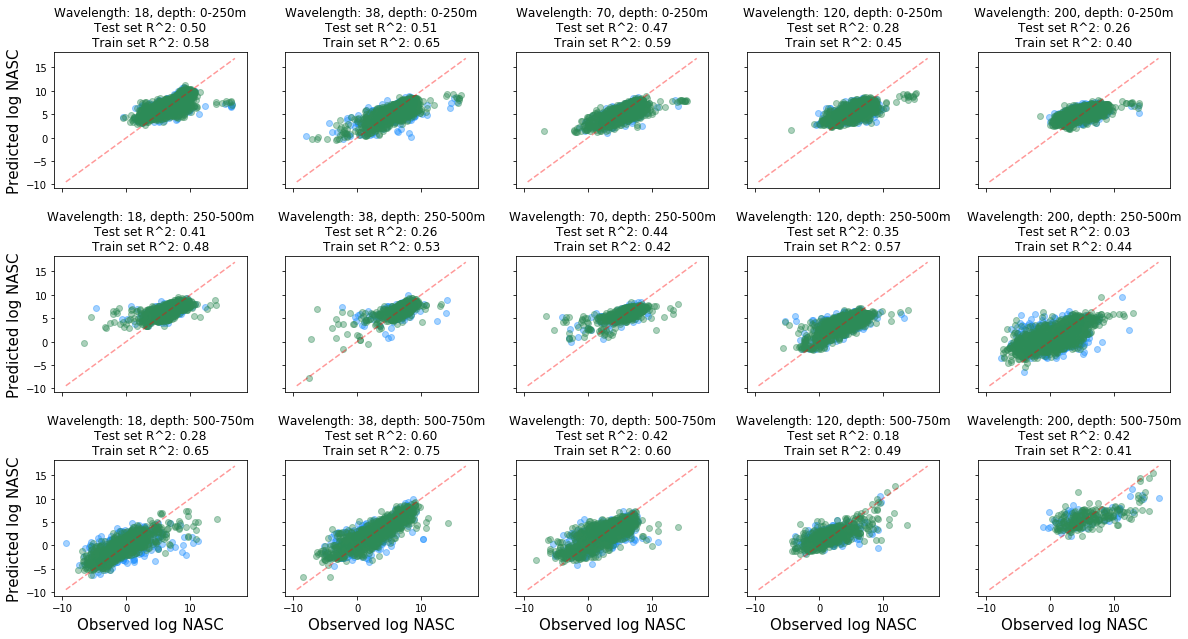

In [16]:
fig, ax = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, sharey=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):
        subd = d.query('wavelength == ' + str(wavelength))
        subd = subd.query("depth_bin == '" + str(depth_bin) + "'")
        x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
        x = preprocessing.scale(x)
        y = subd.log_nasc
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        
        mlp = MLPRegressor(hidden_layer_sizes=(50, 40, 30, 20, 10), max_iter=100000)
        mlp.fit(x_train, y_train)

        y_test_hat = mlp.predict(x_test)
        y_train_hat = mlp.predict(x_train)
        
        ax[j, i].scatter(y_test, y_test_hat, alpha=0.4, c='dodgerblue')
        ax[j, i].scatter(y_train, y_train_hat, alpha = 0.4, c = 'seagreen')
        ax[j, i].plot(yrange, yrange, '--',c='red',alpha = 0.4)
        ax[j, i].set_title('Wavelength: ' + str(wavelength) + ', depth: ' + str(depth_bin) + 
                           '\n' + 'Test set R^2: ' + "%.2f" % r2_score(y_test, y_test_hat) +
                           '\n' + 'Train set R^2: ' + "%.2f" % r2_score(y_train, y_train_hat))
        
        # add axis labels on the edge plots
        if wavelength == wavelengths[0]:
            ax[j, i].set_ylabel('Predicted log NASC', fontsize = 15)
        if depth_bin == depth_bins[-1]:
            ax[j, i].set_xlabel('Observed log NASC', fontsize = 15)
plt.subplots_adjust(hspace=0.5)
#plt.savefig('NN_Train_updatedR2score.png')